In [ ]:
#To build UNet++ we're going to need Tensorflow (deep learning), NumPy (numerical computation) and skimage (image processing) libraries. Also we're going to use matplotlib's color palette for bounding boxes colors.

In [1]:
import pandas as pd
import numpy as np
import zipfile
import os
import glob
import random
import sys

import skimage.io                           #Used for imshow function
import skimage.transform                    #Used for resize function
from skimage.morphology import label        #Used for Run-Length-Encoding RLE to create final submission
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Custom IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

IMG_WIDTH       = 256
IMG_HEIGHT      = 256
IMG_CHANNELS    = 3

print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Skimage      :', skimage.__version__)
print('Tensorflow   :', tf.__version__)

Python       : 3.11.1 (tags/v3.11.1:a7a450f, Dec  6 2022, 19:58:39) [MSC v.1934 64 bit (AMD64)]
Numpy        : 1.23.5
Skimage      : 0.21.0
Tensorflow   : 2.13.0


In [ ]:
#Model hyperparameters Next, we define some configurations for UNet++.

In [43]:
# learning rate
LR = 0.001
# Custom loss function
def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def bce_dice_loss(y_true, y_pred):
    return 0.5 * tf.keras.losses.binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)

NUM_EPOCHS=25

In [ ]:
#Load images. Let's unpack the data. Loads and concatenates images from path/{id}/masks/{id}.png into a numpy array. Check training data

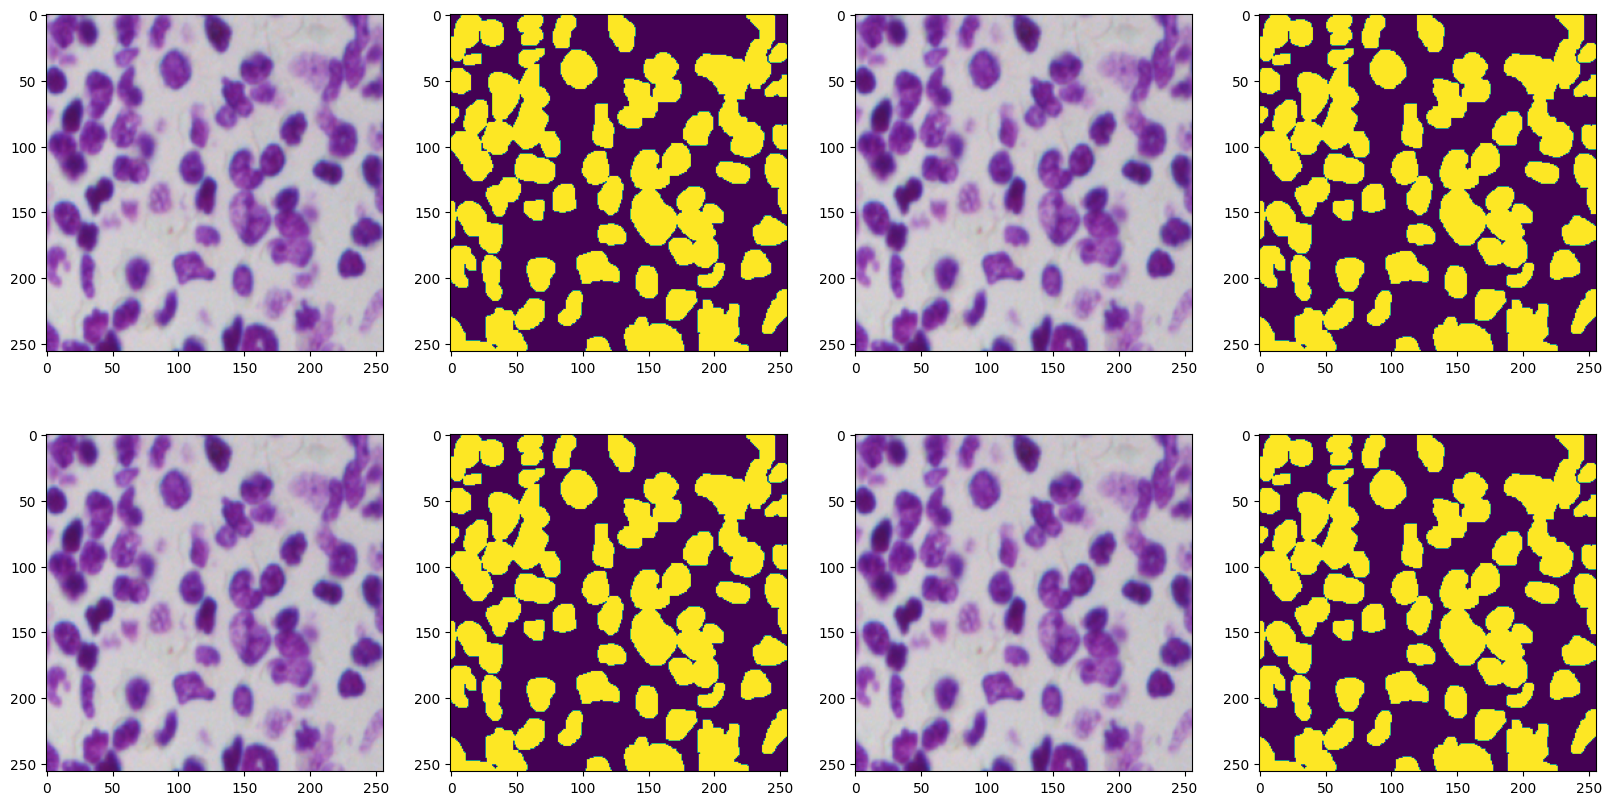

In [46]:
import zipfile
for name_data in ['test', 'train']:
    tmp_zip = zipfile.ZipFile('U-net++/'+name_data+'.zip')
    tmp_zip.extractall(name_data)
    tmp_zip.close()

# to load the data, we will use the convenient skimage lib
def get_X_data(path, output_shape=(None, None)):
    '''
    Loads images from path/{id}/images/{id}.png into a numpy array
    '''
    img_paths = ['{0}/{1}/images/{1}.png'.format(path, id) for id in os.listdir(path)]
    X_data = np.array([skimage.transform.resize(skimage.io.imread(path)[:,:,:3],
                                                output_shape=output_shape,
                                                mode='constant',
                                                preserve_range=True) for path in img_paths], dtype=np.uint8)  #take only 3 channels/bands

    return X_data

def get_Y_data(path, output_shape=(None, None)):
    '''
    Loads and concatenates images from path/{id}/masks/{id}.png into a numpy array
    '''
    img_paths = [glob.glob('{0}/{1}/masks/*.png'.format(path, id)) for id in os.listdir(path)]

    Y_data = []
    for i, img_masks in enumerate(img_paths):  #loop through each individual nuclei for an image and combine them together
        masks = skimage.io.imread_collection(img_masks).concatenate()  #masks.shape = (num_masks, img_height, img_width)
        mask = np.max(masks, axis=0)                                   #mask.shape = (img_height, img_width)
        mask = skimage.transform.resize(mask, output_shape=output_shape+(1,), mode='constant', preserve_range=True)  #need to add an extra dimension so mask.shape = (img_height, img_width, 1)
        Y_data.append(mask)
    Y_data = np.array(Y_data, dtype=np.bool_)

    return Y_data

# Get training data
X_train = get_X_data('train', output_shape=(IMG_HEIGHT,IMG_WIDTH))
# Get training data labels
Y_train = get_Y_data('train', output_shape=(IMG_HEIGHT,IMG_WIDTH))

X_test = get_X_data('test', output_shape=(IMG_HEIGHT,IMG_WIDTH))

TRAIN_PATH = 'train/'

# Check training data
train_ids = next(os.walk(TRAIN_PATH))

f, axarr = plt.subplots(2,4)
f.set_size_inches(20,10)
ix = random.randint(0, len(train_ids[1]))
axarr[0,0].imshow(X_train[ix])
axarr[0,1].imshow(np.squeeze(Y_train[ix]))

axarr[0,2].imshow(X_train[ix])
axarr[0,3].imshow(np.squeeze(Y_train[ix]))

axarr[1,0].imshow(X_train[ix])
axarr[1,1].imshow(np.squeeze(Y_train[ix]))

axarr[1,2].imshow(X_train[ix])
axarr[1,3].imshow(np.squeeze(Y_train[ix]))

plt.show()

In [ ]:
#Image augmentation

In [6]:
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.1, random_state=13)

data_gen_args = dict(rotation_range=45.,
                         width_shift_range=0.1,
                         height_shift_range=0.1,
                         shear_range=0.2,
                         zoom_range=0.2,
                         horizontal_flip=True,
                         vertical_flip=True,
                         fill_mode='reflect')

X_datagen = ImageDataGenerator(**data_gen_args)
Y_datagen = ImageDataGenerator(**data_gen_args)
test_datagen = ImageDataGenerator()
X_datagen_val = ImageDataGenerator()
Y_datagen_val = ImageDataGenerator()

X_datagen.fit(x_train, augment=True, seed=13)
Y_datagen.fit(y_train, augment=True, seed=13)
test_datagen.fit(X_test, augment=True, seed=13)
X_datagen_val.fit(x_test, augment=True, seed=13)
Y_datagen_val.fit(y_test, augment=True, seed=13)

X_train_augmented = X_datagen.flow(x_train,  batch_size=15, shuffle=True, seed=13)
Y_train_augmented = Y_datagen.flow(y_train,  batch_size=15, shuffle=True, seed=13)
test_augmented = test_datagen.flow(X_test, shuffle=False, seed=13)
X_train_augmented_val = X_datagen_val.flow(x_test,  batch_size=15, shuffle=True, seed=13)
Y_train_augmented_val = Y_datagen_val.flow(y_test,  batch_size=15, shuffle=True, seed=13)

train_generator = zip(X_train_augmented, Y_train_augmented)
val_generator = zip(X_train_augmented_val, Y_train_augmented_val)

In [ ]:
#Build a model

In [7]:
pip install pydot

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
pip install graphviz

Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 47.0/47.0 kB ? eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
pip install pydotplus


Defaulting to user installation because normal site-packages is not writeable
     ------------------------------------ 278.7/278.7 kB 419.4 kB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for pydotplus: filename=pydotplus-2.0.2-py3-none-any.whl size=24574 sha256=4e515db21536caaa8585eaa5b309b48d3f3b170167d04f1441feff1bf645c732
  Stored in directory: c:\users\admin\appdata\local\pip\cache\wheels\69\ef\1a\fdcdf2ba9552338ce03a4d1d51e67c1041f084fd853ee414a2
Successfully built pydotplus
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
conda uninstall pydot
conda uninstall pydotplus
conda uninstall graphviz

SyntaxError: invalid syntax (295263666.py, line 1)

In [7]:
tf.keras.backend.clear_session()
from tensorflow.keras.utils import plot_model
nb_filter = [32,64,128,256,512]
# Build U-Net++ model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)


c1 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.5) (c1)
c1 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
c1 = Dropout(0.5) (c1)
p1 = MaxPooling2D((2, 2), strides=(2, 2)) (c1)

c2 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.5) (c2)
c2 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
c2 = Dropout(0.5) (c2)
p2 = MaxPooling2D((2, 2), strides=(2, 2)) (c2)

up1_2 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up12', padding='same')(c2)
conv1_2 = concatenate([up1_2, c1], name='merge12', axis=3)
c3 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1_2)
c3 = Dropout(0.5) (c3)
c3 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
c3 = Dropout(0.5) (c3)

conv3_1 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
conv3_1 = Dropout(0.5) (conv3_1)
conv3_1 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv3_1)
conv3_1 = Dropout(0.5) (conv3_1)
pool3 = MaxPooling2D((2, 2), strides=(2, 2), name='pool3')(conv3_1)

up2_2 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up22', padding='same')(conv3_1)
conv2_2 = concatenate([up2_2, c2], name='merge22', axis=3) #x10
conv2_2 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv2_2)
conv2_2 = Dropout(0.5) (conv2_2)
conv2_2 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv2_2)
conv2_2 = Dropout(0.5) (conv2_2)

up1_3 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up13', padding='same')(conv2_2)
conv1_3 = concatenate([up1_3, c1, c3], name='merge13', axis=3)
conv1_3 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1_3)
conv1_3 = Dropout(0.5) (conv1_3)
conv1_3 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1_3)
conv1_3 = Dropout(0.5) (conv1_3)

conv4_1 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (pool3)
conv4_1 = Dropout(0.5) (conv4_1)
conv4_1 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv4_1)
conv4_1 = Dropout(0.5) (conv4_1)
pool4 = MaxPooling2D((2, 2), strides=(2, 2), name='pool4')(conv4_1)

up3_2 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up32', padding='same')(conv4_1)
conv3_2 = concatenate([up3_2, conv3_1], name='merge32', axis=3) #x20
conv3_2 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv3_2)
conv3_2 = Dropout(0.5) (conv3_2)
conv3_2 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv3_2)
conv3_2 = Dropout(0.5) (conv3_2)

up2_3 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up23', padding='same')(conv3_2)
conv2_3 = concatenate([up2_3, c2, conv2_2], name='merge23', axis=3)
conv2_3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv2_3)
conv2_3 = Dropout(0.5) (conv2_3)
conv2_3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv2_3)
conv2_3 = Dropout(0.5) (conv2_3)

up1_4 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up14', padding='same')(conv2_3)
conv1_4 = concatenate([up1_4, c1, c3, conv1_3], name='merge14', axis=3)
conv1_4 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1_4)
conv1_4 = Dropout(0.5) (conv1_4)
conv1_4 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1_4)
conv1_4 = Dropout(0.5) (conv1_4)

conv5_1 = Conv2D(512, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (pool4)
conv5_1 = Dropout(0.5) (conv5_1)
conv5_1 = Conv2D(512, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv5_1)
conv5_1 = Dropout(0.5) (conv5_1)

up4_2 = Conv2DTranspose(nb_filter[3], (2, 2), strides=(2, 2), name='up42', padding='same')(conv5_1)
conv4_2 = concatenate([up4_2, conv4_1], name='merge42', axis=3) #x30
conv4_2 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv4_2)
conv4_2 = Dropout(0.5) (conv4_2)
conv4_2 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv4_2)
conv4_2 = Dropout(0.5) (conv4_2)

up3_3 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up33', padding='same')(conv4_2)
conv3_3 = concatenate([up3_3, conv3_1, conv3_2], name='merge33', axis=3)
conv3_3 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv3_3)
conv3_3 = Dropout(0.5) (conv3_3)
conv3_3 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv3_3)
conv3_3 = Dropout(0.5) (conv3_3)

up2_4 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up24', padding='same')(conv3_3)
conv2_4 = concatenate([up2_4, c2, conv2_2, conv2_3], name='merge24', axis=3)
conv2_4 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv2_4)
conv2_4 = Dropout(0.5) (conv2_4)
conv2_4 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv2_4)
conv2_4 = Dropout(0.5) (conv2_4)

up1_5 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up15', padding='same')(conv2_4)
conv1_5 = concatenate([up1_5, c1, c3, conv1_3, conv1_4], name='merge15', axis=3)
conv1_5 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1_5)
conv1_5 = Dropout(0.5) (conv1_5)
conv1_5 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1_5)
conv1_5 = Dropout(0.5) (conv1_5)

nestnet_output_4 = Conv2D(1, (1, 1), activation='sigmoid', kernel_initializer = 'he_normal',  name='output_4', padding='same')(conv1_5)

model = Model([inputs], [nestnet_output_4])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR), loss=bce_dice_loss)


# tf.keras.utils.plot_model(
#     model,
#     show_shapes=False,
#     show_dtype=False,
#     show_layer_names=True,
#     rankdir='TB',
#     expand_nested=False,
#     dpi=46,
#     layer_range=None
# )

In [ ]:
#Running the model

In [9]:
print(len(X_train))

670


In [11]:
checkpoint = ModelCheckpoint('best_model.hdf5' , 
                             monitor = 'val_loss', 
                             verbose = 1, 
                             save_best_only=True,
                             mode = 'min',
                             save_weights_only=True,
                             save_freq='epoch'
                            )
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3,
                              patience=5, min_lr=0.00005)

callbacks_list = [checkpoint, reduce_lr]

# Fit model
history = model.fit(train_generator,  
                    validation_data=val_generator,
                    steps_per_epoch=len(X_train)/(20),
                    validation_steps=10,
                    callbacks=callbacks_list,
                    epochs=NUM_EPOCHS, 
                    verbose=1,)

Epoch 1/25
34/33 [==============================] - ETA: -7s - loss: -0.1644
Epoch 1: val_loss improved from inf to 0.03324, saving model to best_model.hdf5
33/33 [==============================] - 522s 16s/step - loss: -0.1644 - val_loss: 0.0332 - lr: 0.0010
Epoch 2/25
34/33 [==============================] - ETA: -7s - loss: -0.5212
Epoch 2: val_loss improved from 0.03324 to -0.23149, saving model to best_model.hdf5
33/33 [==============================] - 538s 16s/step - loss: -0.5212 - val_loss: -0.2315 - lr: 0.0010
Epoch 3/25
34/33 [==============================] - ETA: -7s - loss: -0.5766
Epoch 3: val_loss improved from -0.23149 to -0.31408, saving model to best_model.hdf5
33/33 [==============================] - 539s 16s/step - loss: -0.5766 - val_loss: -0.3141 - lr: 0.0010
Epoch 4/25
34/33 [==============================] - ETA: -7s - loss: -0.6587
Epoch 4: val_loss improved from -0.31408 to -0.73916, saving model to best_model.hdf5
33/33 [==============================] - 546

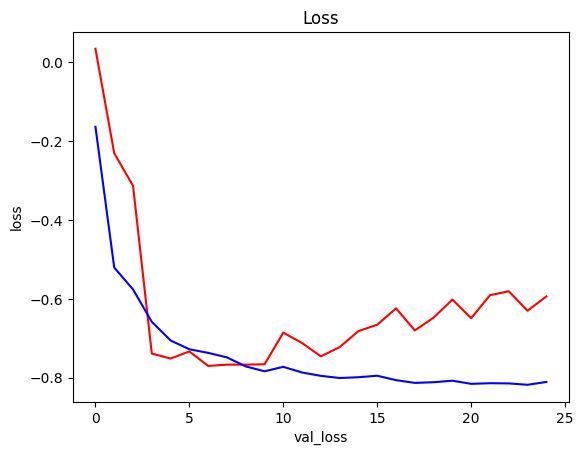

In [16]:
def plot_loss_history(history):
    # validation losses
    val_loss = history.history['val_loss']
    loss = history.history['loss']

    plt.title('Loss')
    plt.plot(val_loss, 'r', loss, 'b')
    plt.xlabel('val_loss')
    plt.ylabel('loss')
    plt.show()
    
plot_loss_history(history)

21/21 [==============================] - 120s 6s/step


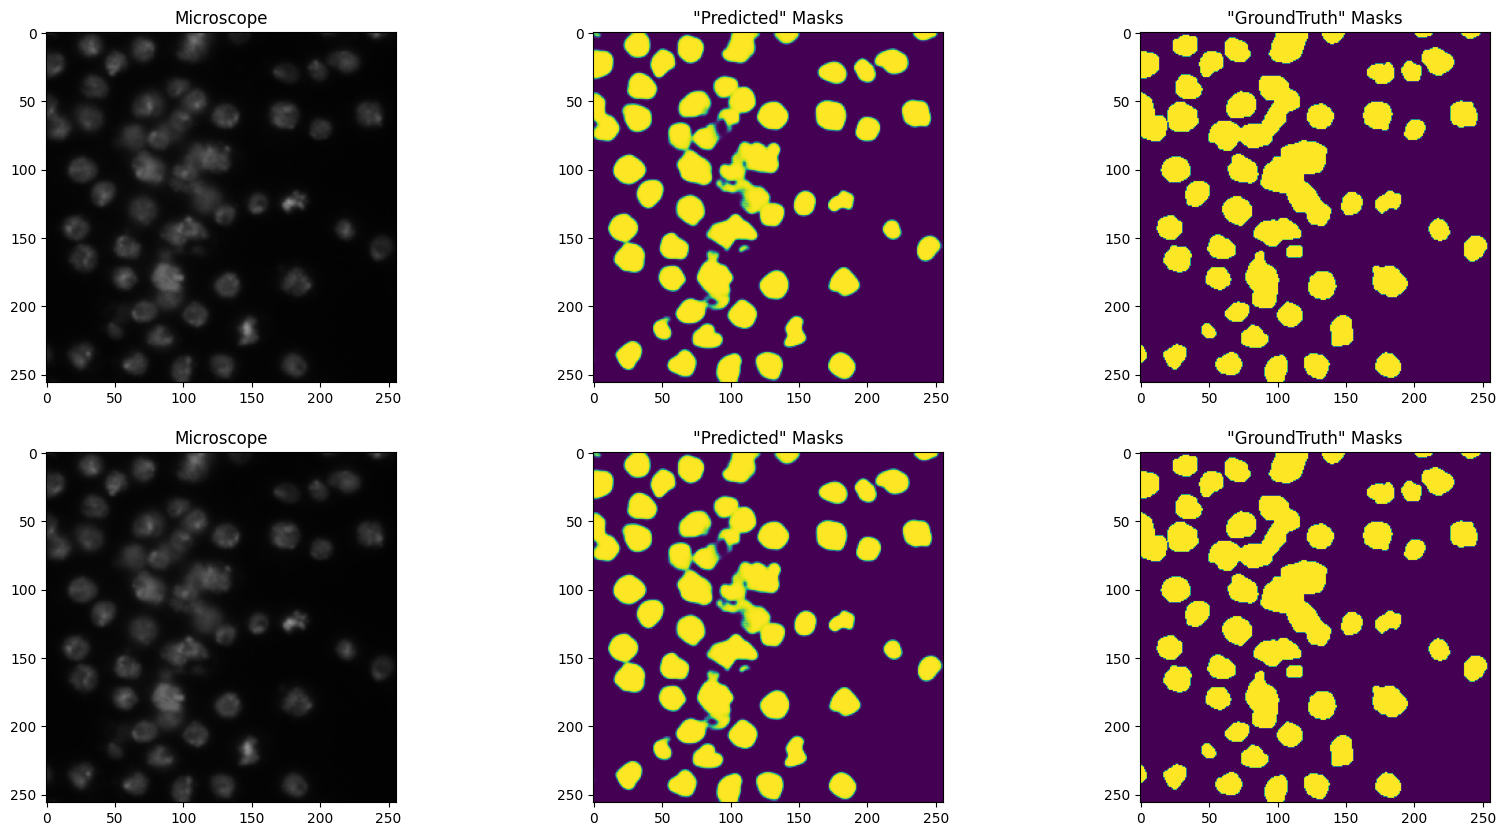

In [13]:
Y_predict = model.predict(X_train, verbose=1)
train_ids = next(os.walk('train'))
test_ids = next(os.walk('test'))
# Check predict data
f, axarr = plt.subplots(2,3)
f.set_size_inches(20,10)
ix = random.randint(0, len(train_ids[1]))
axarr[0,0].imshow(X_train[ix])
axarr[0,0].set_title('Microscope')
axarr[0,1].imshow(np.squeeze(Y_predict[ix]))
axarr[0,1].set_title('"Predicted" Masks')
axarr[0,2].imshow(np.squeeze(Y_train[ix]))
axarr[0,2].set_title('"GroundTruth" Masks')

axarr[1,0].imshow(X_train[ix])
axarr[1,0].set_title('Microscope')
axarr[1,1].imshow(np.squeeze(Y_predict[ix]))
axarr[1,1].set_title('"Predicted" Masks')
axarr[1,2].imshow(np.squeeze(Y_train[ix]))
axarr[1,2].set_title('"GroundTruth" Masks')

plt.show()

3/3 [==============================] - 11s 3s/step
(256, 256, 3)


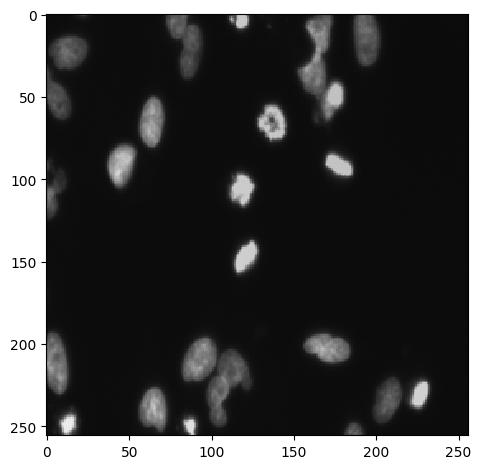

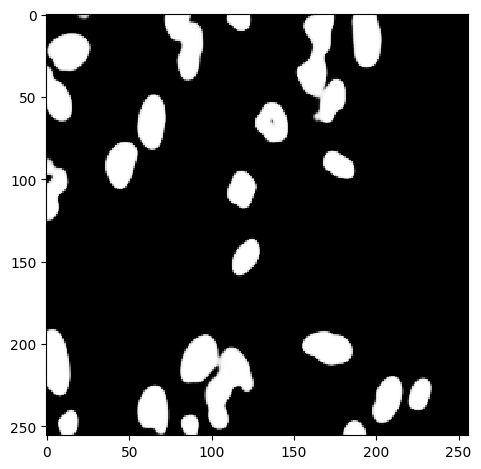

In [15]:
# Use model to predict test labels
Y_hat = model.predict(X_test, verbose=1)
Y_hat.shape
idx = random.randint(0, len(test_ids[1]))
print(X_test[idx].shape)
skimage.io.imshow(X_test[idx])
plt.show();
skimage.io.imshow(Y_hat[idx][:,:,0])
plt.show();

# Lung Image Segmentation using our model for Respiratory Disease Verification 

In [2]:
images = os.listdir("ChestXray/train/image")
masks = os.listdir("ChestXray/train/mask")

In [3]:
v_images = os.listdir("ChestXray/val/image")
v_masks = os.listdir("ChestXray/val/mask")

now lets randomly check if everything's okay

In [4]:
print(len(images)==len(masks))
print(len(v_images)==len(v_masks))

True
True


In [5]:
masks[:10]

['cxrmask_0.jpeg',
 'cxrmask_1.jpeg',
 'cxrmask_10.jpeg',
 'cxrmask_100.jpeg',
 'cxrmask_1000.jpeg',
 'cxrmask_10000.jpeg',
 'cxrmask_10001.jpeg',
 'cxrmask_10002.jpeg',
 'cxrmask_10003.jpeg',
 'cxrmask_10004.jpeg']

In [6]:
images[:10]

['cxrimage_0.png',
 'cxrimage_1.png',
 'cxrimage_10.png',
 'cxrimage_100.png',
 'cxrimage_1000.png',
 'cxrimage_10000.png',
 'cxrimage_10001.png',
 'cxrimage_10002.png',
 'cxrimage_10003.png',
 'cxrimage_10004.png']

In [7]:
masks.sort()
images.sort()
v_masks.sort()
v_images.sort()

In [8]:
temp = 0
while temp<20:
  print(images[temp].split("_")[1].split(".")[0] == masks[temp].split("_")[1].split(".")[0])
  temp+=1

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [9]:
import random
from PIL import Image
i = random.randint(0,len(images)-1)
img = np.asarray(Image.open(os.path.join("ChestXray/train/image",images[i])))
mask = np.asarray(Image.open(os.path.join("ChestXray/train/mask",masks[i])))
print(img.shape,mask.shape)

(512, 512, 4) (512, 512, 3)


In [10]:
len(images)

16932

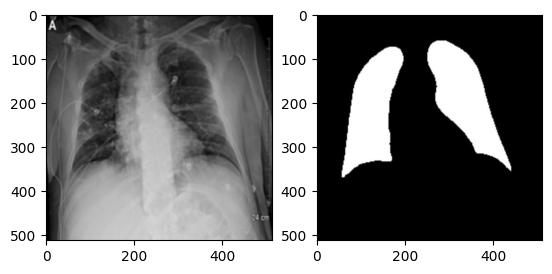

In [11]:
plt.subplot(1,2,1)
plt.imshow(img[:,:,:3]) #rgba to rgb

plt.subplot(1,2,2)
plt.imshow(mask)

plt.show()

In [13]:
def make_dataset(validation=False):
  x = []
  y = []
  if(validation):
    for i,(image,mask) in enumerate(zip(v_images[:1500],v_masks[:1500])):
      print("\r"+str(i+1)+"/"+str(len(v_images)),end="")

      image = Image.open(os.path.join("ChestXray/val/image",image)).convert('L')
      mask = Image.open(os.path.join("ChestXray/val/mask",mask)).convert('L')

      image = np.asarray(image.resize((256,256)))/255.
      mask = np.asarray(mask.resize((256,256)))/255.

      x.append(image)
      y.append(mask)
  else:
    for i,(image,mask) in enumerate(zip(images[:3500],masks[:3500])):
      print("\r"+str(i+1)+"/"+str(len(images)),end="")
      
      image = Image.open(os.path.join("ChestXray/train/image",image)).convert('L')
      mask = Image.open(os.path.join("ChestXray/train/mask",mask)).convert('L')

      image = np.asarray(image.resize((256,256)))/255.
      mask = np.asarray(mask.resize((256,256)))/255.

      x.append(image)
      y.append(mask)

  return np.array(x),np.array(y)

In [14]:
x,y = make_dataset()

3500/16932

In [15]:
v_x,v_y = make_dataset(True)

1500/2117

In [118]:
x,y = np.expand_dims(x,axis=-1),np.expand_dims(y,axis=-1)
v_x,v_y = np.expand_dims(v_x,axis=-1),np.expand_dims(v_y,axis=-1)

In [16]:
x,y = np.stack((x,) * 3, axis=-1),np.stack((y,) * 3, axis=-1)
v_x,v_y = np.stack((v_x,) * 3, axis=-1),np.stack((v_y,) * 3, axis=-1)

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_gen_args = dict(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode="nearest",
    horizontal_flip=True,
    vertical_flip=True,
)

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

seed = 1

image_generator = image_datagen.flow(
    x,
    batch_size=16,
    seed=seed)

mask_generator = mask_datagen.flow(
    y,
    batch_size=16,
    seed=seed)

train_generator = zip(image_generator, mask_generator)

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_test_datagen = ImageDataGenerator()
mask_test_datagen = ImageDataGenerator()

seed = 1

image_test_generator = image_test_datagen.flow(
    v_x,
    batch_size=16,
    seed=seed)

mask_test_generator = mask_test_datagen.flow(
    v_y,
    batch_size=16,
    seed=seed)

valid_generator = zip(image_test_generator, mask_test_generator)

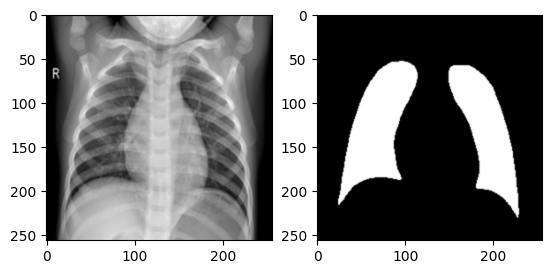

In [19]:
i = random.randint(0,len(x))

img = x[i]
mask = y[i]

plt.subplot(1,2,1)
plt.imshow(np.squeeze(img))

plt.subplot(1,2,2)
plt.imshow(np.squeeze(mask))

plt.show()

In [89]:
model.compile(optimizer="adam",loss=tf.keras.losses.binary_crossentropy,metrics="accuracy")
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR), loss=bce_dice_loss)

In [90]:
ver_history = model.fit(train_generator,
                        epochs=20,
                        validation_data=valid_generator,
                        steps_per_epoch = 50,
                        validation_steps=10,
                        callbacks=callbacks_list,
                        verbose=1)


# history = model.fit(train_generator,  
#                     validation_data=valid_generator,
#                     steps_per_epoch=len(X_train)/(25),
#                     validation_steps=10,
#                     callbacks=callbacks_list,
#                     epochs=NUM_EPOCHS, 
#                     verbose=1,)

Epoch 1/20
50/50 [==============================] - ETA: 0s - loss: 0.7896 - accuracy: 0.6340
Epoch 1: val_loss did not improve from -0.77051
50/50 [==============================] - 228s 4s/step - loss: 0.7896 - accuracy: 0.6340 - val_loss: 0.5748 - val_accuracy: 0.7262 - lr: 0.0010
Epoch 2/20
50/50 [==============================] - ETA: 0s - loss: 0.6422 - accuracy: 0.6587
Epoch 2: val_loss did not improve from -0.77051
50/50 [==============================] - 222s 4s/step - loss: 0.6422 - accuracy: 0.6587 - val_loss: 0.5636 - val_accuracy: 0.7346 - lr: 0.0010
Epoch 3/20
50/50 [==============================] - ETA: 0s - loss: 0.6258 - accuracy: 0.6695
Epoch 3: val_loss did not improve from -0.77051
50/50 [==============================] - 219s 4s/step - loss: 0.6258 - accuracy: 0.6695 - val_loss: 0.5641 - val_accuracy: 0.7353 - lr: 0.0010
Epoch 4/20
50/50 [==============================] - ETA: 0s - loss: 0.6057 - accuracy: 0.6874
Epoch 4: val_loss did not improve from -0.77051
50/

In [91]:
model.save("u-net++.h5")

C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [20]:
i = random.randint(0,len(v_x)-1)

original = v_x[i].copy()
original_mask = v_y[i].copy()

mask = model.predict(np.expand_dims(original,axis=0))


segmented = np.squeeze(original).copy()
segmented[np.squeeze(mask)<0.2] = 0

plt.subplot(1,4,1)
plt.imshow(np.squeeze(original),cmap="gray")
plt.title("x-ray")
plt.axis("off")

plt.subplot(1,4,2)
plt.imshow(segmented,cmap="gray")
plt.title("segmented")
plt.axis("off")

plt.subplot(1,4,3)
plt.imshow(np.squeeze(mask[0]),cmap="gray")
plt.title("predicted mask")
plt.axis("off")

plt.subplot(1,4,4)
plt.imshow(np.squeeze(original_mask),cmap="gray")
plt.title("  original mask")
plt.axis("off")

plt.show()

NameError: name 'model' is not defined

In [22]:
new_model = tf.keras.models.load_model('u-net++.h5')

In [23]:
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 lambda (Lambda)             (None, 256, 256, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 32)         896       ['lambda[0][0]']              
                                                                                                  
 dropout (Dropout)           (None, 256, 256, 32)         0         ['conv2d[0][0]']              
                                                                                              

                                                                                                  
 conv2d_8 (Conv2D)           (None, 128, 128, 64)         73792     ['merge22[0][0]']             
                                                                                                  
 merge12 (Concatenate)       (None, 256, 256, 64)         0         ['up12[0][0]',                
                                                                     'dropout_1[0][0]']           
                                                                                                  
 dropout_23 (Dropout)        (None, 32, 32, 256)          0         ['conv2d_23[0][0]']           
                                                                                                  
 conv2d_15 (Conv2D)          (None, 64, 64, 128)          147584    ['dropout_14[0][0]']          
                                                                                                  
 dropout_8

                                                                                                  
 dropout_26 (Dropout)        (None, 128, 128, 64)         0         ['conv2d_26[0][0]']           
                                                                                                  
 conv2d_18 (Conv2D)          (None, 256, 256, 32)         36896     ['merge14[0][0]']             
                                                                                                  
 conv2d_27 (Conv2D)          (None, 128, 128, 64)         36928     ['dropout_26[0][0]']          
                                                                                                  
 dropout_18 (Dropout)        (None, 256, 256, 32)         0         ['conv2d_18[0][0]']           
                                                                                                  
 dropout_27 (Dropout)        (None, 128, 128, 64)         0         ['conv2d_27[0][0]']           
          

1/1 [==============================] - 0s 186ms/step


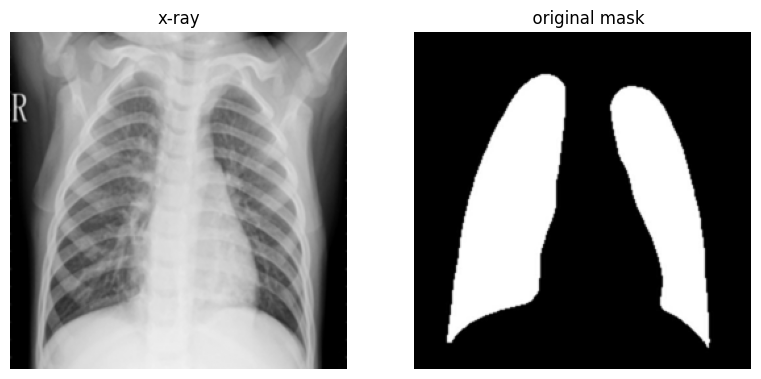

In [39]:
i = random.randint(0,len(v_x)-1)

original = v_x[i].copy()
original_mask = v_y[i].copy()

mask = new_model.predict(np.expand_dims(original,axis=0))


segmented = np.squeeze(original).copy()
segmented[np.squeeze(mask)<0.2] = 0

plt.figure(figsize=(20, 10))

plt.subplot(1,4,1)
plt.imshow(np.squeeze(original),cmap="gray")
plt.title("x-ray")
plt.axis("off")

# plt.subplot(1,4,2)
# plt.imshow(segmented,cmap="gray")
# plt.title("segmented")
# plt.axis("off")

# plt.subplot(1,4,3)
# plt.imshow(np.squeeze(mask[0]),cmap="gray")
# plt.title("predicted mask")
# plt.axis("off")

plt.subplot(1,4,2)
plt.imshow(np.squeeze(original_mask),cmap="gray")
plt.title("  original mask")
plt.axis("off")

plt.show()

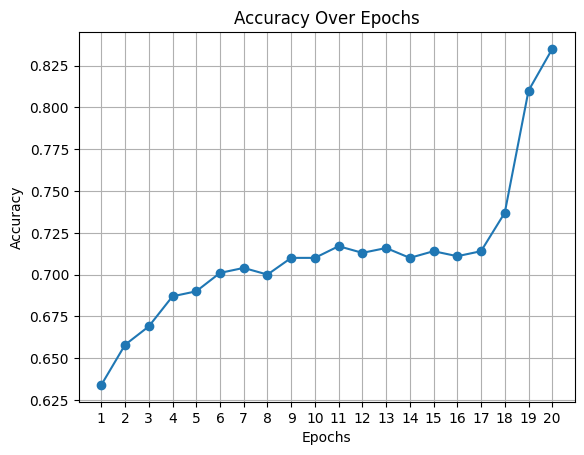

In [33]:
#accuracy vs epochs
import matplotlib.pyplot as plt


accuracy_history = [0.634, 0.658, 0.669, 0.687, 0.690, 0.701, 0.704, 0.700, 0.710, 0.710, 0.717, 0.713, 0.7159, 0.710, 0.714, 0.711, 0.714, 0.737, 0.810, 0.835]


epochs = range(1, len(accuracy_history) + 1)


plt.plot(epochs, accuracy_history, marker='o')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(epochs)
plt.grid(True)
plt.show()

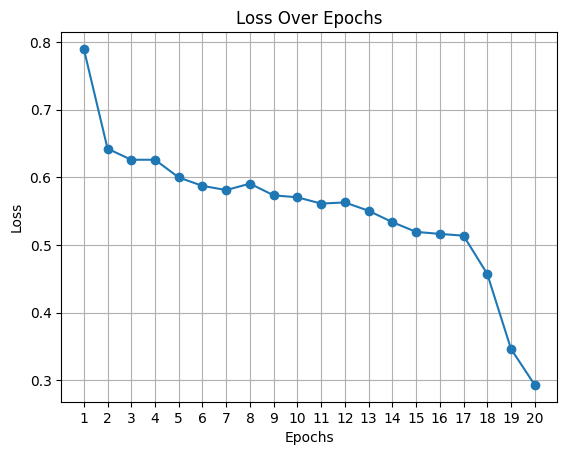

In [35]:
#loss vs epochs
loss_history = [0.7896, 0.6422, 0.6258, 0.6258, 0.5996, 0.5872, 0.5810, 0.5905, 0.5732, 0.5703, 0.5610, 0.5627, 0.5504, 0.5336, 0.5192, 0.5162, 0.5136, 0.4570, 0.3462, 0.2930]


epochs = range(1, len(loss_history) + 1)

plt.plot(epochs, loss_history, marker='o')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.grid(True)
plt.show()

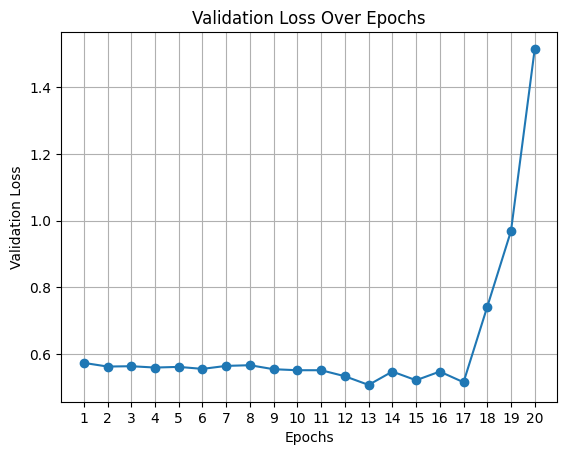

In [2]:
#loss vs epochs
import matplotlib.pyplot as plt
Validation_loss_history = [0.574,0.563,0.564,0.560,0.562,0.556,0.565,0.567,0.555,0.552,0.552,0.534,0.508,0.548,0.522,0.548,0.516,0.742,0.969,1.514]


epochs = range(1, len(Validation_loss_history) + 1)

plt.plot(epochs, Validation_loss_history, marker='o')
plt.title('Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.xticks(epochs)
plt.grid(True)
plt.show()

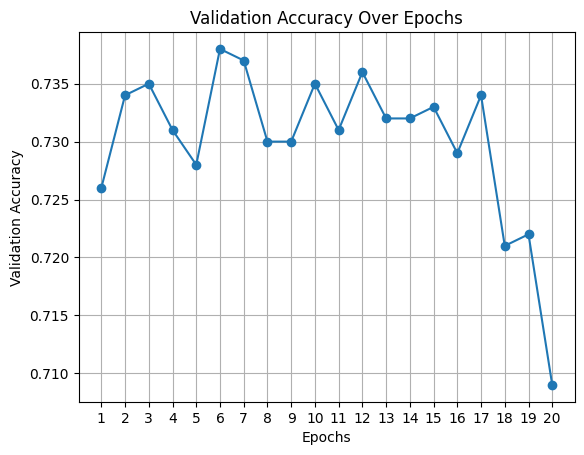

In [3]:
#loss vs epochs
Validation_accuracy_history = [0.726, 0.734, 0.735, 0.731, 0.728, 0.738, 0.737, 0.730, 0.730, 0.735, 0.731, 0.736, 0.732, 0.732, 0.733, 0.729, 0.734, 0.721, 0.722, 0.709]


epochs = range(1, len(Validation_accuracy_history) + 1)

plt.plot(epochs, Validation_accuracy_history, marker='o')
plt.title('Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.xticks(epochs)
plt.grid(True)
plt.show()